In [3]:
from os import listdir
from os.path import isfile, join
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.utils import AnalysisException
from pyspark.sql.functions import sum as spark_sum, col, collect_list

# conf = (SparkConf()
#     .set("spark.driver.maxResultSize", "10g") \
#     .set("spark.driver.memory", "20g"))
# sc = SparkContext(conf=conf)
# sqlContext = SQLContext(sc)

spark = SparkSession.builder \
    .appName("QueryScript") \
    .config("spark.driver.maxResultSize", "10g") \
    .config("spark.driver.memory", "20g") \
    .getOrCreate()

def query_table(file_name):
    try:
        df = spark.read.parquet(file_name)
        df.createOrReplaceTempView("test_df")
        result = spark.sql("""
            SELECT s, t, c_list, size(c_list) as num_pages,
                aggregate(c_list, 0, (x, y) -> x + y) as details_sum
            FROM test_df ORDER BY details_sum DESC
        """)
        return result
    except AnalysisException as e:
        # Catch and ignore errors
        print(f"Error processing {file_name}: {e}")
        return None
    
query_table("spark-warehouse/output_table_2199").show(10)

+--------------------+-------------------+--------------------+---------+-----------+
|                   s|                  t|              c_list|num_pages|details_sum|
+--------------------+-------------------+--------------------+---------+-----------+
|https://sante.jou...|fr.journaldesfemmes|[27, 25, 27, 25, ...|        9|        233|
|https://sante.jou...|  com.ccmbg.astatic|[12, 12, 12, 12, ...|        9|        108|
|https://sante.jou...|fr.journaldesfemmes|    [27, 27, 24, 27]|        4|        105|
|https://sante.jou...|fr.journaldesfemmes|                [94]|        1|         94|
|https://sante.jou...|fr.journaldesfemmes|                [94]|        1|         94|
|https://sante.jou...|fr.journaldesfemmes|                [94]|        1|         94|
|https://sante.jou...|fr.journaldesfemmes|                [93]|        1|         93|
|https://sante.jou...|fr.journaldesfemmes|                [93]|        1|         93|
|https://sante.jou...|fr.journaldesfemmes|            

In [4]:
import pandas as pd
from os import listdir
from os.path import join
from pyspark.sql import SparkSession
from tqdm import tqdm 
from pyspark.sql.functions import sum as spark_sum, collect_list, col

def query_all_tables(directory):
    files = [f for f in listdir(directory)]
    
    all_results = []
    spark = SparkSession.builder.appName("Example").getOrCreate()
    for file_name in tqdm(files):
        result_df = query_table(join(directory, file_name))
        if result_df:
            # Convert each PySpark DataFrame to Pandas DataFrame
            pandas_df = result_df.toPandas()
            all_results.append(pandas_df)

    print(len(all_results))

    # Concatenate all Pandas DataFrames
    grouped_df = pd.concat(all_results) if all_results else None
    
    # Group by s and t using Pandas operations
    grouped_df = grouped_df.groupby(["s", "t"]).agg(
        {"num_pages": "sum", "details_sum": "sum", "c_list": lambda x: x.tolist()}
    ).reset_index()
    grouped_df["ratio"] = grouped_df["details_sum"] / grouped_df["num_pages"]
    
    spark.stop()  # Stop the SparkSession to release resources
    return grouped_df

df_link_dists = query_all_tables("spark-warehouse/")

spark-warehouse/output_table_0476
Error processing spark-warehouse/output_table_2208: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
Error processing spark-warehouse/output_table_0012: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
Error processing spark-warehouse/output_table_0003: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
Error processing spark-warehouse/output_table_0013: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
Error processing spark-warehouse/output_table_0001: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
Error processing spark-warehouse/output_table_0011: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
Error processing spark-warehouse/output_table_0014: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema fo

In [23]:
import pandas as pd
import numpy as np
from wat_extract_links import ExtractLinksJob

def reverse_url(url):
    components = url.split('.')
    reversed_url = '.'.join(components[::-1])
    return reversed_url

def is_substring(row, col_a, col_b):
    return row[col_a] not in row[col_b]

df_link_dists['t'] = df_link_dists['t'].apply(reverse_url)
df_link_dists['s_d'] = df_link_dists['s'].apply(ExtractLinksJob.get_surt_host)
df_link_dists['s_d'] = df_link_dists['s_d'].apply(reverse_url)

# labels = pd.read_csv('../data/attributes.csv')[['url','label']]
labels = pd.read_csv('../data/news_ratings_11k.csv')[['domain', 'pc1']]
labels.columns = ['url','label']
df_link_dists_labelled = df_link_dists.merge(right=labels, left_on='t', right_on='url', how='inner')
df_link_dists_labelled = df_link_dists_labelled[~df_link_dists_labelled.apply(lambda row: row['t'] in row['s'], axis=1)]
df_link_dists_labelled = df_link_dists_labelled[~df_link_dists_labelled.apply(lambda row: row['s'] in row['t'], axis=1)]
df_link_dists_labelled['link_dist'] = df_link_dists_labelled['link_dist'].apply(np.concatenate)
df_link_dists_labelled.describe()

,total_num_pages,total_details_sum,ratio,label
count,1.0,1.0,1.0,1.000000
mean,1.0,1.0,1.0,0.717433
std,NaN,NaN,NaN,NaN
min,1.0,1.0,1.0,0.717433
25%,1.0,1.0,1.0,0.717433
50%,1.0,1.0,1.0,0.717433
75%,1.0,1.0,1.0,0.717433
max,1.0,1.0,1.0,0.717433


## TODO: Multiplicity

In [5]:
from scipy.stats import skew
import seaborn as sns
import math

def aggregate_link_dist(link_dist_list):
    result_list = []
    for sublist in link_dist_list:
        result_list.extend(sublist)
    return [result_list]

def link_dist_metrics(df):
    df['mean'] = df['link_dist'].apply(np.mean)
    df['skew'] = df['link_dist'].apply(skew)
    df['variance'] = df['link_dist'].apply(np.var)
    df['stddev'] = df['variance'].apply(math.sqrt)
    df['links_per_page'] = df['total_details_sum'] / df['total_num_pages']
    return df

# Define aggregation functions for each column
page_aggregation_dict = {
    'link_dist': aggregate_link_dist,
    'total_details_sum': 'sum',
    'total_num_pages': 'sum',
    'label': 'mean',
}
df_link_dists_page_aggregated = df_link_dists_labelled.groupby(['s']).agg(page_aggregation_dict).reset_index()
df_link_dists_page_aggregated = link_dist_metrics(df_link_dists_page_aggregated)
df_link_dists_page_aggregated[df_link_dists_page_aggregated['stddev']>10].head(10)

,s,link_dist,total_details_sum,total_num_pages,label,mean,skew,variance,stddev,links_per_page
11614,http://acecomments.mu.nu/?blog=86&post=361006,"[[1, 1, 1, 42, 1, 1, 1, 1]]",49,8,0.587638,6.125000,"[nan, nan, nan, nan, nan, nan, nan, nan]",183.859375,13.559475,6.125000
11706,http://acecomments.mu.nu/?blog=86&post=363404,"[[1, 1, 1, 1, 1, 1, 10, 1, 39]]",56,9,0.644341,6.222222,"[nan, nan, nan, nan, nan, nan, nan, nan, nan]",142.172840,11.923625,6.222222
11811,http://acecomments.mu.nu/?blog=86&post=369232,"[[1, 1, 1, 1, 38, 1, 1]]",44,7,0.628718,6.285714,"[nan, nan, nan, nan, nan, nan, nan]",167.632653,12.947303,6.285714
11813,http://acecomments.mu.nu/?blog=86&post=369269,"[[1, 29, 1, 1, 1, 1]]",34,6,0.597040,5.666667,"[nan, nan, nan, nan, nan, nan]",108.888889,10.434984,5.666667
17587,http://bucknermelton.com/2022/05,"[[18, 1, 12, 1, 1, 1, 6, 3, 1, 1, 1, 1, 1, 1, ...",179,31,0.733038,5.774194,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",285.465140,16.895714,5.774194
17595,http://bucknermelton.com/2023/10,"[[1, 1, 1, 1, 1, 1, 1, 60, 3, 1, 28, 1, 1, 8, ...",133,25,0.751986,5.320000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",158.617600,12.594348,5.320000
17598,http://bucknermelton.com/author/associated-press,"[[48, 39, 2, 3, 3, 1, 7]]",103,7,0.623066,14.714286,"[nan, nan, nan, nan, nan, nan, nan]",340.204082,18.444622,14.714286
17623,http://bucknermelton.com/author/lifezette,"[[2, 1, 1, 9, 2, 4, 40, 1, 1, 9, 3, 50]]",123,12,0.571375,10.250000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",253.187500,15.911867,10.250000
17624,http://bucknermelton.com/author/rusty-weiss-2,"[[1, 1, 2, 4, 70, 1, 1, 1, 3, 1, 12, 1, 1, 2, ...",122,23,0.704957,5.304348,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",197.429112,14.050947,5.304348
17638,http://bucknermelton.com/category/1q2022fundra...,"[[1, 1, 1, 3, 1, 6, 1, 1, 55, 1, 2, 4, 1, 1, 1]]",80,15,0.772598,5.333333,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",178.222222,13.349990,5.333333


,s_d,variance,total_details_sum,stddev,total_num_pages
10,247.libero.it,1.902918,108131,0.781151,67491
17,7rangers.com,0.080428,80593,0.229721,77594
34,ace.mu.nu,0.157464,76192,0.082370,62670
48,advocate.com,11.446303,101289,0.660555,21883
162,berfrois.com,0.005155,274796,0.020417,274066


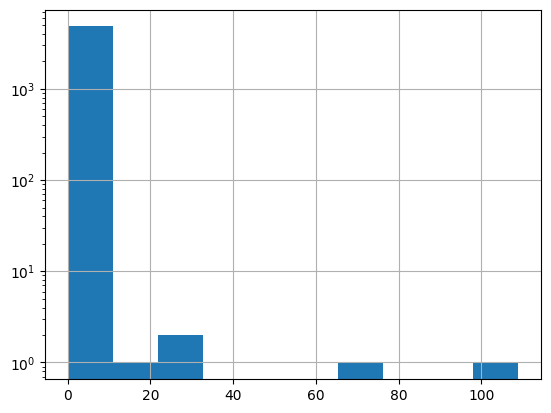

In [6]:
df_link_dists_page_aggregated['s_d'] = df_link_dists_page_aggregated['s'].apply(ExtractLinksJob.get_surt_host)
df_link_dists_page_aggregated['s_d'] = df_link_dists_page_aggregated['s_d'].apply(reverse_url)
domain_aggregation_dict = {
    'variance': 'mean',
    'total_details_sum': 'sum',
    'stddev': 'mean',
    'total_num_pages': 'sum',
}
df_link_dists_domain_aggregated = df_link_dists_page_aggregated.groupby('s_d').agg(domain_aggregation_dict).reset_index()

import matplotlib.pyplot as plt
df_link_dists_domain_aggregated['stddev'].hist()
plt.yscale('log')

df_link_dists_domain_aggregated[df_link_dists_domain_aggregated['total_details_sum']>50000].head(5)

In [8]:
backlinks = pd.read_csv('../data/filtered_backlinks.csv')['domain_from'].unique()
outlinks = pd.read_csv('../data/filtered_outlinks.csv')['domain_to'].unique()
news = pd.read_csv('../data/attributes.csv')['url'].unique()

print('init backlinks:', len(backlinks))
print('init outlinks:', len(outlinks))
print('init news:', len(news))
print('back -> out overlap: ', len(backlinks[np.in1d(backlinks, outlinks)]))
print('back -> news overlap: ', len(backlinks[np.in1d(backlinks, news)]))
print('out -> news overlap: ', len(outlinks[np.in1d(outlinks, news)]))

backlinks = backlinks[~np.in1d(backlinks, news)]
backlinks = backlinks[~np.in1d(backlinks, outlinks)]
outlinks = outlinks[~np.in1d(outlinks, news)]

print('clean backlinks:', len(backlinks))
print('clean outlinks:', len(outlinks))
print('clean news:', len(news))

df_news_profiles = df_link_dists_domain_aggregated[df_link_dists_domain_aggregated['s_d'].isin(news)]
df_outlink_profiles = df_link_dists_domain_aggregated[df_link_dists_domain_aggregated['s_d'].isin(outlinks)]
df_backlink_profiles = df_link_dists_domain_aggregated[df_link_dists_domain_aggregated['s_d'].isin(backlinks)]

init backlinks: 12373
init outlinks: 7487
init news: 4158
back -> out overlap:  1208
back -> news overlap:  637
out -> news overlap:  764
clean backlinks: 10857
clean outlinks: 6723
clean news: 4158


## Weighted sum over reliability labels

/tmp/ipykernel_71822/253895782.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_backlink_dists['link_dist'] = df_cc_backlink_dists['link_dist'].apply(np.concatenate)
/tmp/ipykernel_71822/253895782.py:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'page_links_skew': skew(page_link_dist),
/tmp/ipykernel_71822/253895782.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the groupin

,s_d,weighted_average,sum_len_link_dist,sum_link_dist,page_links_skew,page_links_mean,page_links_var
1,12160.info,0.654862,1830.0,2625.0,16.790145,7.037534,1.616374e+03
33,avrn.tv,0.855205,326.0,329.0,0.000524,82.250000,6.441188e+03
60,catholicamericanthinker.com,0.707541,2103.0,3625.0,9.007724,34.855769,6.833008e+04
62,ce.cn,0.686085,17.0,17.0,0.000000,8.500000,5.625000e+01
63,celebritytalker.com,0.690896,778.0,8228.0,4.358438,374.000000,2.729647e+06
71,citizen-news.org,0.621001,2385.0,2522.0,8.667687,31.525000,4.850987e+04
92,creativityalliance.com,0.726358,9105.0,9942.0,4.765844,80.177419,1.192030e+05
99,cynlibsoc.com,0.612439,28606.0,34395.0,5.796440,142.128099,2.892574e+05
129,eveilhomme.com,0.674264,2718.0,2907.0,10.801161,24.225000,5.126701e+04
152,frettin.is,0.757342,1402.0,2482.0,13.030259,14.346821,2.374868e+04


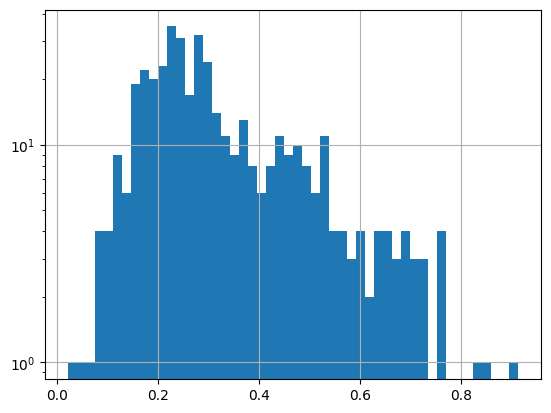

In [16]:
import pandas as pd

def weighted_average(group):
    total_weighted_sum = 0
    total_weight = 0
    total_len_link_dist = 0
    total_sum_link_dist = 0
    page_link_dist = []
    
    for index, row in group.iterrows():
        num_links = sum(row['link_dist'])
        total_weighted_sum += num_links * (1-row['label'])
        total_weight += num_links
        total_len_link_dist += len(row['link_dist'])
        total_sum_link_dist += num_links
        page_link_dist.append(num_links)

    if total_weight == 0:
        return pd.Series({'weighted_average': 0, 'sum_len_link_dist': 0, 'sum_link_dist': 0, 'page_links_skew':0, 'page_links_mean':0, 'page_links_var':0})
    
    return pd.Series({'weighted_average': total_weighted_sum / total_weight,
                      'sum_len_link_dist': total_len_link_dist,
                      'sum_link_dist': total_sum_link_dist,
                      'page_links_skew': skew(page_link_dist), 
                      'page_links_mean': np.mean(page_link_dist), 
                      'page_links_var': np.var(page_link_dist)})

df_cc_domain_dists = df_link_dists_labelled.groupby(['s_d', 't']).agg(page_aggregation_dict).reset_index()
df_cc_backlink_dists = df_cc_domain_dists[df_cc_domain_dists['s_d'].isin(backlinks)]
df_cc_backlink_dists['link_dist'] = df_cc_backlink_dists['link_dist'].apply(np.concatenate)
df_cc_backlink_ratings = df_cc_backlink_dists.groupby('s_d').apply(weighted_average).reset_index()
df_cc_backlink_ratings['weighted_average'].hist(bins=50)
plt.yscale('log')
df_cc_backlink_ratings[df_cc_backlink_ratings['weighted_average']>0.6]

In [22]:
df_backlink_profile_weighted = df_backlink_profiles.merge(
    right=df_cc_backlink_ratings[['weighted_average','s_d','page_links_skew','page_links_mean','page_links_var']], 
    on='s_d', 
    how='inner'
)
print(df_backlink_profiles.shape[0])
print(df_cc_backlink_ratings.shape[0])
print(df_backlink_profile_weighted.shape[0])
df_backlink_profile_weighted['total_mean'] = df_backlink_profile_weighted['total_details_sum'] / df_backlink_profile_weighted['total_num_pages']
df_backlink_profile_weighted.drop(columns=['s_d']).corr()

418
418
418


,variance,total_details_sum,stddev,total_num_pages,weighted_average,page_links_skew,page_links_mean,page_links_var,total_mean
variance,1.000000,0.309738,0.752198,0.002981,0.128103,0.063974,0.141897,0.728062,0.277958
total_details_sum,0.309738,1.000000,0.435883,0.835768,0.038576,0.124627,0.204977,0.377996,0.135080
stddev,0.752198,0.435883,1.000000,0.053926,0.068628,0.169933,0.145955,0.755765,0.296380
total_num_pages,0.002981,0.835768,0.053926,1.000000,0.033042,0.051697,0.177687,0.015722,-0.023116
weighted_average,0.128103,0.038576,0.068628,0.033042,1.000000,0.060618,0.056769,0.042727,0.000683
page_links_skew,0.063974,0.124627,0.169933,0.051697,0.060618,1.000000,-0.125510,0.000965,0.104648
page_links_mean,0.141897,0.204977,0.145955,0.177687,0.056769,-0.125510,1.000000,0.211311,0.453801
page_links_var,0.728062,0.377996,0.755765,0.015722,0.042727,0.000965,0.211311,1.000000,0.275857
total_mean,0.277958,0.135080,0.296380,-0.023116,0.000683,0.104648,0.453801,0.275857,1.000000


In [20]:
# df_backlink_profile_weighted[df_backlink_profile_weighted['variance']<10]['variance'].hist()
df_backlink_profile_weighted[df_backlink_profile_weighted['variance']>3]

,s_d,variance,total_details_sum,stddev,total_num_pages,weighted_average,page_links_skew,page_links_mean,page_links_var
5,400since1619.com,50.316609,4544,5.683835,1240,0.393023,7.046990,24.042328,1.216092e+04
28,atlasofsurveillance.org,11.788679,27086,2.051492,4150,0.210846,22.322609,53.848907,9.126448e+05
32,augustinefou.com,9.898557,2945,1.766149,1131,0.154734,5.823641,58.900000,5.604353e+04
50,bucknermelton.com,205.237118,84250,11.026334,15126,0.484054,20.221502,187.222222,6.122353e+06
90,cowboyron.com,45.814877,2630,1.854138,337,0.258350,3.382226,27.684211,3.111227e+03
105,deeppoliticsforum.com,3.742293,2997,0.693128,1450,0.362119,8.371262,7.291971,4.560656e+02
106,derwaechter.net,4.420725,8762,0.740902,5059,0.468681,12.869648,17.665323,7.017674e+03
122,electionlawblog.org,43.400319,65045,6.570794,15287,0.302183,16.963654,181.183844,4.821004e+06
124,entensity.net,77.976815,18973,5.648130,2266,0.466757,16.404774,47.911616,3.077832e+05
125,ep4pro.org,46.182351,15399,2.710161,3431,0.317198,12.867173,43.134454,1.152871e+05


/home/peter/miniconda3/envs/lsr/lib/python3.12/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)


<Axes: xlabel='label', ylabel='mean'>

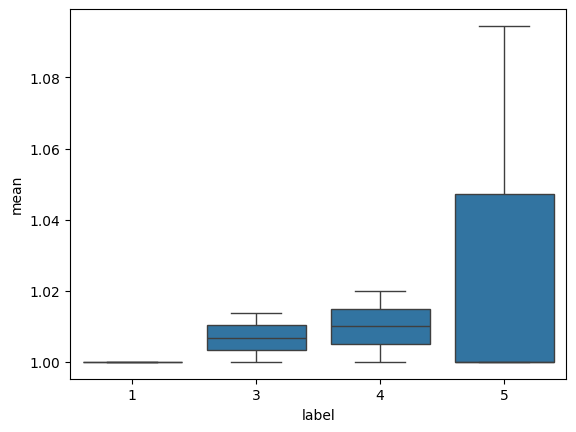

In [ ]:

df_link_source_dists_labelled = df_link_dists_labelled.groupby(['s', 'label'])['link_dist'].agg(list).reset_index()
df_link_source_dists_labelled['link_dist'] = df_link_source_dists_labelled['link_dist'].apply(np.concatenate)

# # Reset the index to make 's' and 'label' regular columns
# df_link_source_dists_labelled = df_link_source_dists_labelled.reset_index()
df_link_source_dists_labelled.head()


# df_label_dists = df_label_dists.reset_index(drop=True)
# df_label_dists = pd.DataFrame(df_label_dists)
# # df_label_dists_exploded = df_label_dists.explode('skew')
# # df_label_dists['skew'] = df_label_dists['skew'].apply(np.concatenate)
# # df_label_dists['skew_filtered'] = df_label_dists['skew']#.apply(lambda x: [value for value in x if value > 10 and value != 29])
# sns.boxplot(x='label', y='skew', data=df_label_dists.explode('skew'),log_scale=True)

df_link_source_dists_labelled['mean'] = df_link_source_dists_labelled['link_dist'].apply(np.mean)
df_link_source_dists_labelled['skew'] = df_link_source_dists_labelled['link_dist'].apply(skew)
# df_link_source_dists_labelled = df_link_dists_labelled.groupby(['s', 'label'])['skew'].agg(list).reset_index()
sns.boxplot(x='label', y='mean', data=df_link_source_dists_labelled.explode('mean'), showfliers=False)

<Axes: xlabel='label', ylabel='link_dist_filtered'>

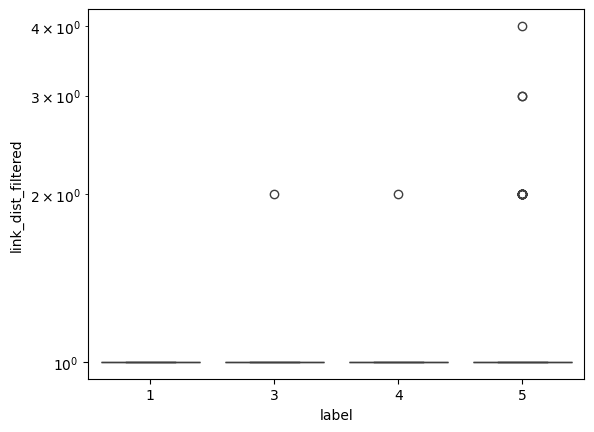

In [ ]:
import seaborn as sns
df_label_dists = df_link_dists_labelled.groupby('label')['link_dist'].agg(list).reset_index()
df_label_dists['link_dist'] = df_label_dists['link_dist'].apply(np.concatenate)
df_label_dists['link_dist_filtered'] = df_label_dists['link_dist']#.apply(lambda x: [value for value in x if value > 10 and value != 29])
sns.boxplot(x='label', y='link_dist_filtered', data=df_label_dists.explode('link_dist_filtered'),log_scale=True)

In [ ]:
df_label_source_dists = df_link_dists_labelled.groupby('')['link_dist'].agg(list).reset_index()
